# 1. Imports

In [1]:
# scikit-learn
from sklearn import set_config # return pd.DataFrame from transformers
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# others
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import numpy as np
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import plot_decision_tree, generate_anomalies, explain_prediction_dt, explain_prediction_iso, plot_final

<hr>

# 2. Settings

In [2]:
# set sklearn functions to output pd.DataFrames
set_config(transform_output='pandas')

# plot figures with higher resolutions
plt.rcParams['figure.dpi'] = 150

<hr>

# 3.Preprocessing

## 3.1 General Preprocessing

In [3]:
# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

In [4]:
# TODO: Decide, whether to drop Sex or not

# drop the index and the nominal feature 'sex'
df.drop(columns=['Sex'], inplace=True)

In [5]:
df

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
611,3=Cirrhosis,62,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
612,3=Cirrhosis,64,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
613,3=Cirrhosis,64,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
614,3=Cirrhosis,46,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [6]:
# seperate features and label
X = df.drop(columns='Category')
y = df['Category']

In [7]:
# numerically encode labels whilst storing their names
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [8]:
# extract class names from label encoder
class_names = label_encoder.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

class_names

['Blood Donor', 'suspect Blood Donor', 'Hepatitis', 'Fibrosis', 'Cirrhosis']

In [9]:
# create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42)

## 3.2 Missing Data

### 3.2.1 Inspection

In [10]:
# calculate the # of missing values per feature
X_missing = X.isnull().sum()

print("Missing Values per Feature:\n")
print(X_missing)

Missing Values per Feature:

Age      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
dtype: int64


### 3.2.2 Imputation

In [11]:
imputer = KNNImputer(n_neighbors=5, weights='distance') # initialize the imputer

## 3.3 Pipeline

In [12]:
# combine all transformers from preprocessing to pipeline
preprocessing = Pipeline(steps=[('imputation', imputer)])

<hr>

# 4.  Decision Tree Classifier

## 4.1 Training

In [13]:
# initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

In [14]:
# encapsulate the decision tree in a pipeline
decision_tree = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('tree', clf)
    ])

In [15]:
# train the decision tree
#decision_tree.fit(X_train.values, y_train)
decision_tree.fit(X_train.values, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputation',
                                  KNNImputer(weights='distance'))])),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])

## 4.2 Evaluation

In [16]:
# predict classes from the test set
y_pred = decision_tree.predict(X_test.values)

In [17]:
# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

In [18]:
# print summary
print(f'Using a depth of {clf.get_depth()}, the tree achieves {round(np.multiply(accuracy, 100), 2)} % accuracy ')

Using a depth of 5, the tree achieves 88.21 % accuracy 


## 4.3 Visualization

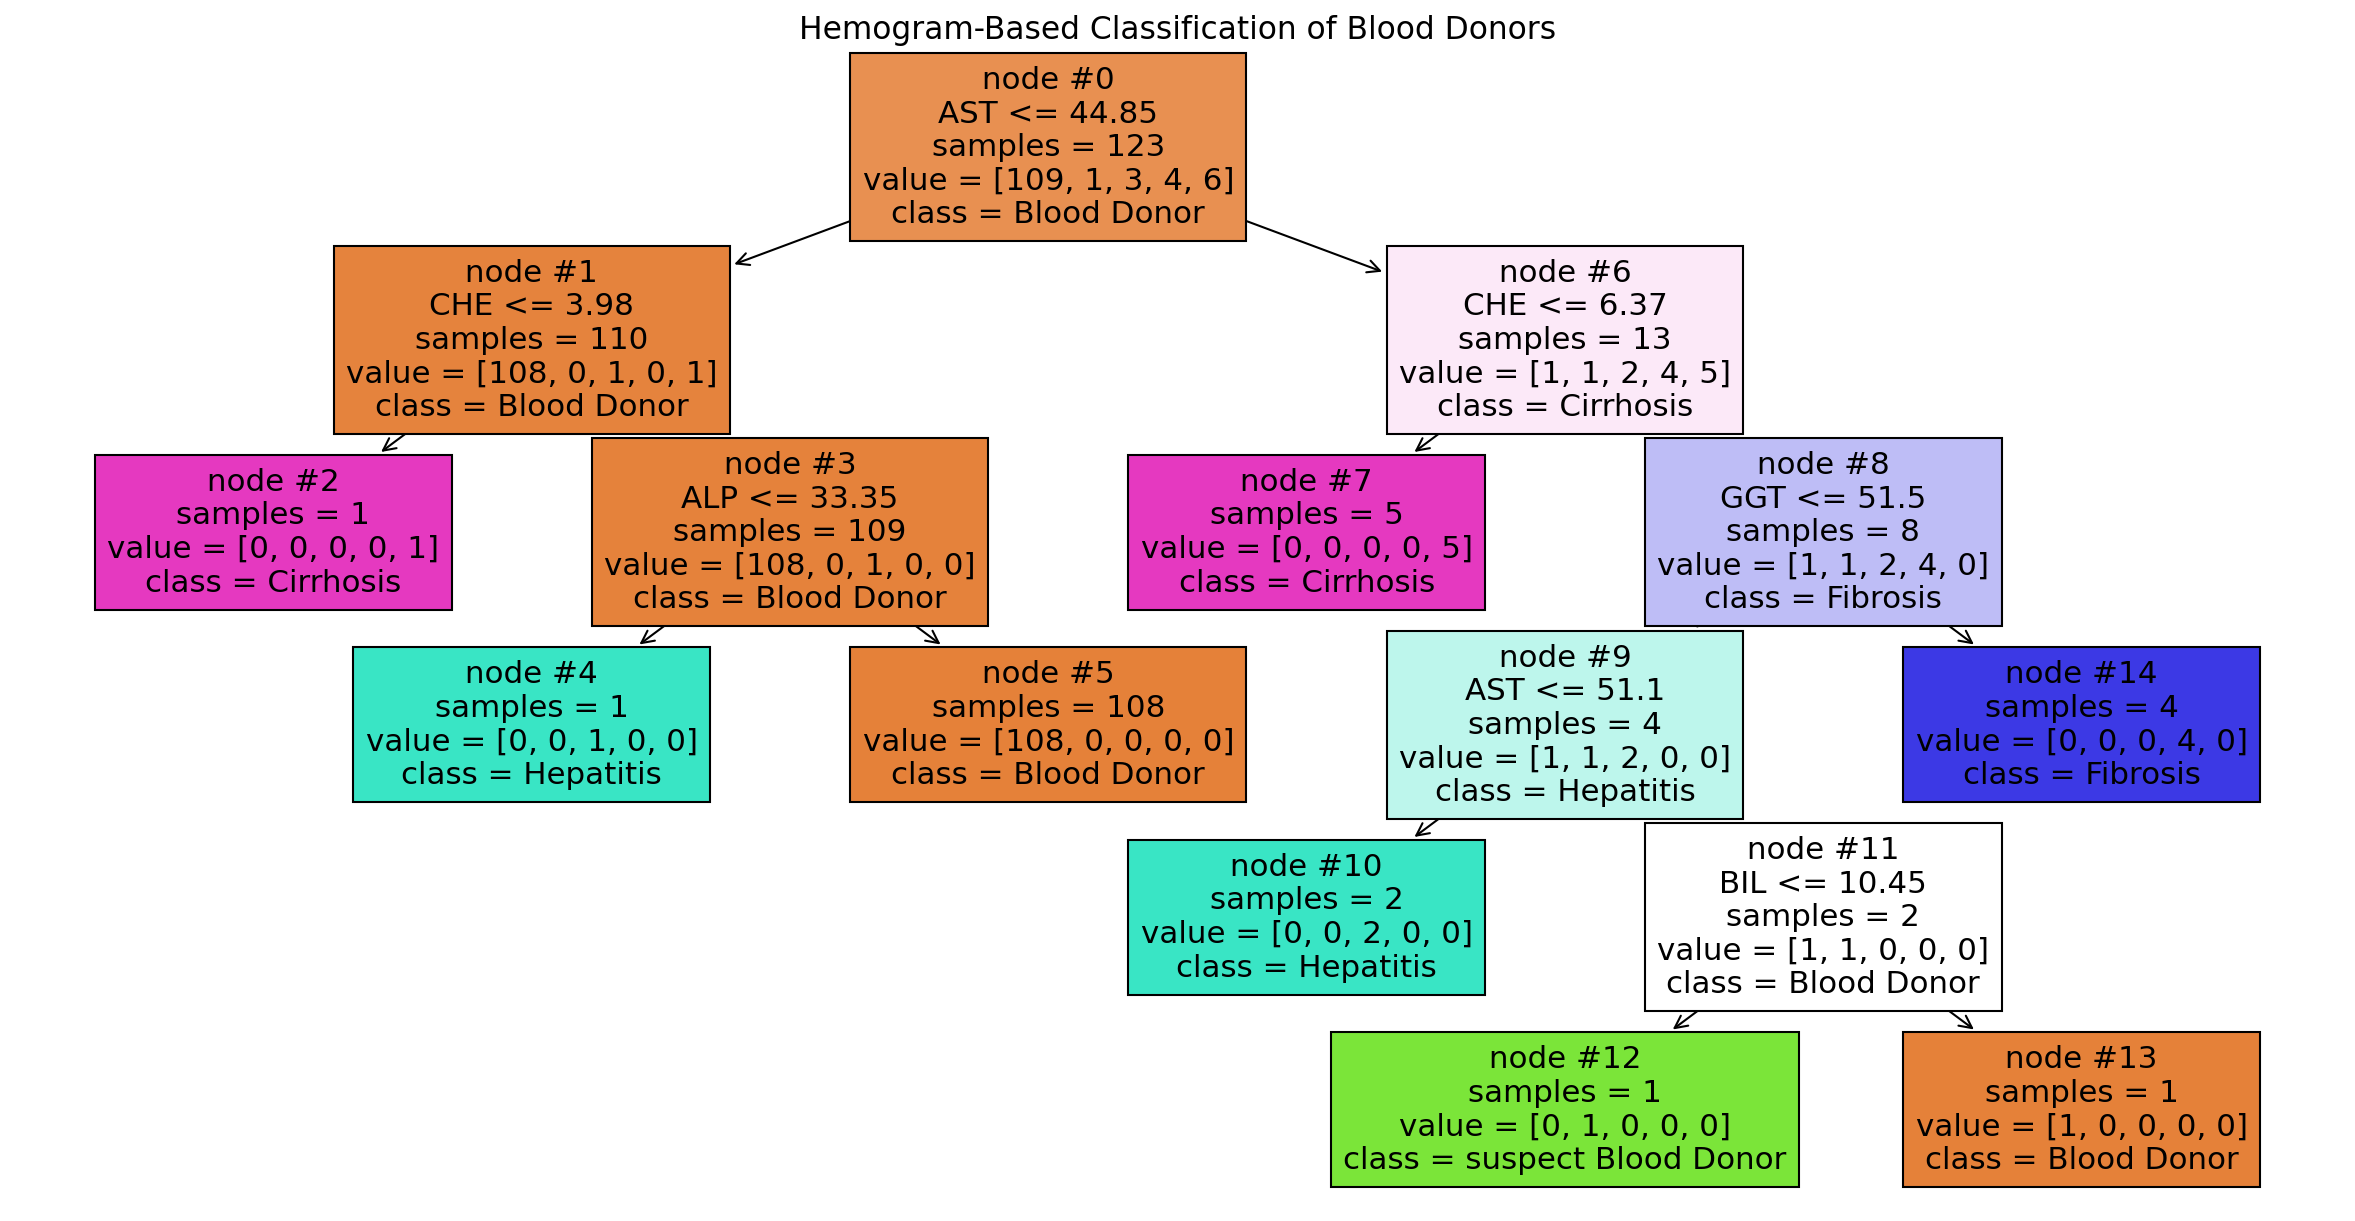

In [19]:
plot_decision_tree(decision_tree=clf, feature_names=list(X.columns), class_names=class_names)

# 5. Pipeline

# Note that warnings are thrown, because our function predicts each patient, so one row at a time, which results in X having no feature name. Due to the fact that we generate a few samples we can guarantee the right oder of the features put into our pipeline 

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
import pandas as pd 
import warnings

# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

label_encoder_sex = LabelEncoder()
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])

X = df.drop(columns=["Category"])
column_order = [col for col in X.columns if col != 'Sex'] + ['Sex']
X = X[column_order]
y = df["Category"]

y_copy = y.copy()

label_encoder_names = LabelEncoder() 
y = label_encoder_names.fit_transform(y)

class_names = label_encoder_names.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

numerical_columns = ["Age","ALB","ALP","ALT","AST","BIL","CHE","CHOL","CREA","GGT","PROT"]

knn = KNeighborsRegressor(n_neighbors=5)
iterative_imputer = IterativeImputer(estimator=knn, add_indicator=False)
imputer = ColumnTransformer([("imputer", iterative_imputer, numerical_columns)],
                            remainder="passthrough",
                            verbose_feature_names_out=False).set_output(transform="pandas")

class Combiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dt = DecisionTreeClassifier(max_depth=5)
        self.iso = IsolationForest()
        self.rs = RobustScaler()
        self.pca = PCA(n_components=2)
        self.prepedData = None

    def scale_pca_fit_transform (self,X):
        rs_data= self.rs.fit_transform(X)
        pca_data= self.pca.fit_transform(rs_data)
        return pca_data

    def scale_pca_transform (self, X):
        rs_data= self.rs.transform(X)
        pca_data= self.pca.transform(rs_data)
        return pca_data

    def fit(self, X, y=None):
        self.dt.fit(X, y)
        self.prepedData = self.scale_pca_fit_transform(X)
        index_blood_donor = y_copy[y_copy=="0=Blood Donor"].index

        # Get only data from Blood donors
        blood_donor=self.prepedData.iloc[index_blood_donor,:]
        self.iso.fit(blood_donor)
        

    def transform(self, sample):
        prepedData_iso = self.scale_pca_transform(sample)
        
        plot_decision_tree(self.dt, feature_names=list(sample.columns), class_names=class_names)


        for index in sample.index:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                print("Predicted output for Patient with index:", index)
                row_dt = sample.loc[index,:]
                sample_2d_dt = row_dt.values.reshape(1,-1)
                explain_prediction_dt(self.dt, sample_2d_dt, class_names)
                
                row_iso = prepedData_iso.loc[index,:]
                sample_2d_iso = row_iso.values.reshape(1,-1)
                explain_prediction_iso(self.iso, sample_2d_iso)
        return prepedData_iso
            

pipeline = Pipeline([("imputer", imputer),
                    ('combiner', Combiner())
                    ])

pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  IterativeImputer(estimator=KNeighborsRegressor()),
                                                  ['Age', 'ALB', 'ALP', 'ALT',
                                                   'AST', 'BIL', 'CHE', 'CHOL',
                                                   'CREA', 'GGT', 'PROT'])],
                                   verbose_feature_names_out=False)),
                ('combiner', Combiner())])

## 6. Test the generated samples

In [21]:
anomalies =generate_anomalies(30)

In [22]:
anomalies

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,64,m,36,135,142,226,17,25,6,25,246,40
1,19,m,16,74,157,233,23,22,9,50,192,74
2,48,m,15,25,125,172,6,3,12,9,46,96
3,62,m,53,115,158,198,18,23,8,10,273,46
4,26,m,18,170,54,306,7,12,8,18,96,47
5,70,m,55,122,41,39,35,8,9,50,114,49
6,45,f,51,112,63,245,37,19,3,63,33,88
7,63,f,32,188,69,94,16,21,3,44,265,87
8,70,f,42,175,23,278,3,20,4,6,58,37
9,64,m,37,161,112,344,38,17,11,69,45,44


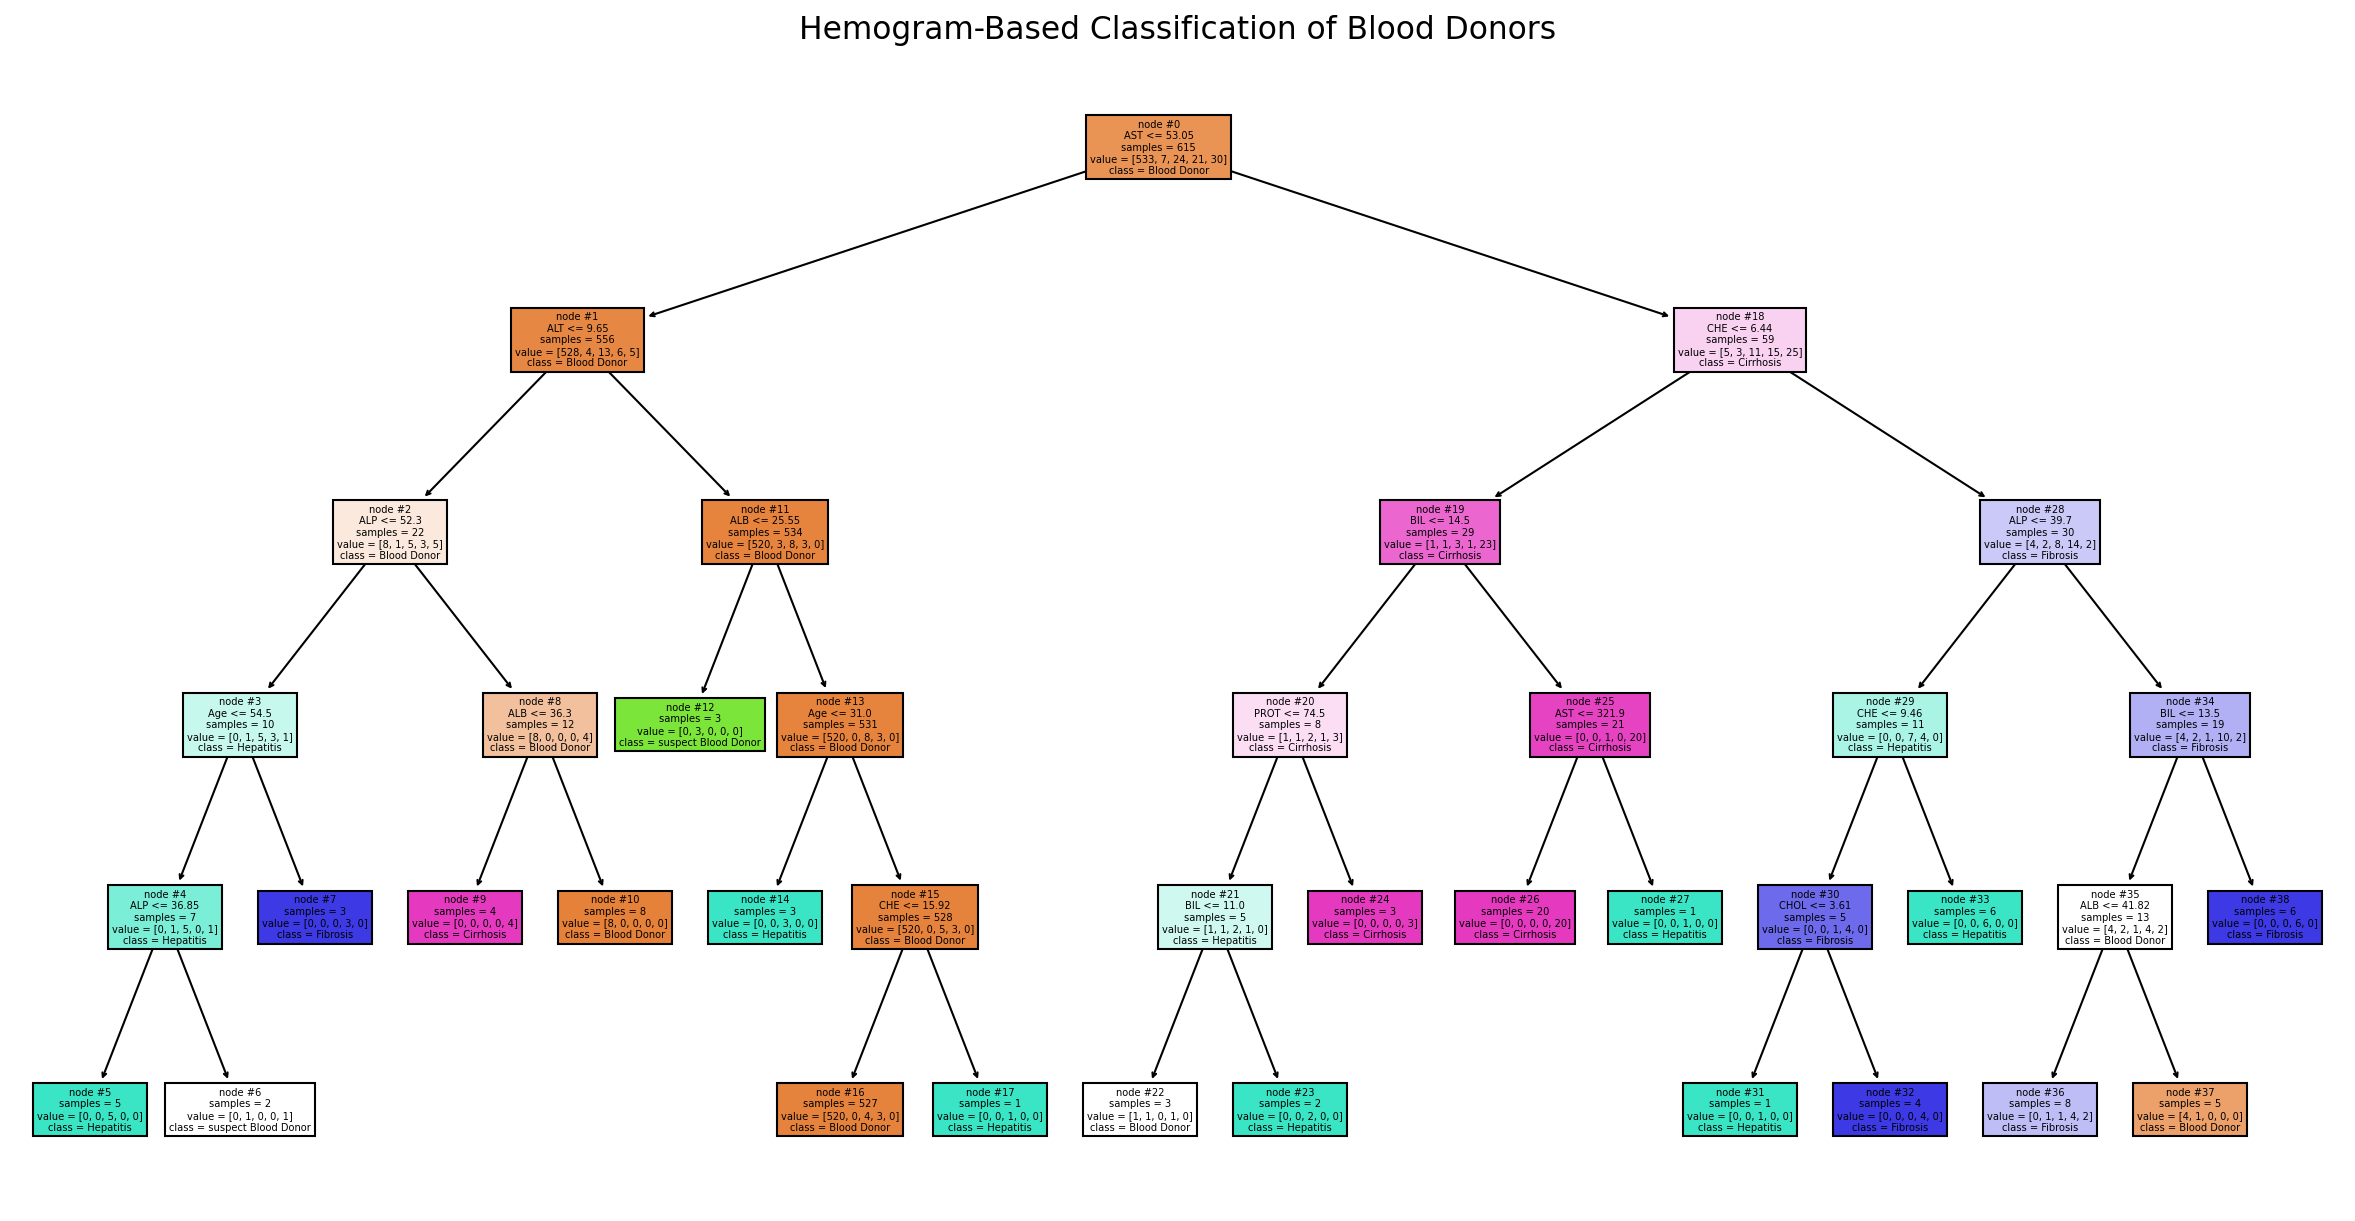

Predicted output for Patient with index: 0
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33755729] 

Predicted output for Patient with index: 1
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33755729] 

Predicted output for Patient with index: 2
Predicted Class: Cirrhosis
Path taken: Nodes 0, 18, 19, 20 and 24
This patient shows an anomaly
Calculated value for the anomaly is: [-0.3369908] 

Predicted output for Patient with index: 3
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34 and 38
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33755729] 

Predicted output for Patient with index: 4
Predicted Class: Fibrosis
Path taken: Nodes 0, 18, 28, 34, 35 and 36
This patient shows an anomaly
Calculated value for the anomaly is: [-0.33755729] 

Predicted output for Patient with index: 

In [23]:
label_encoder_sex = LabelEncoder()
anomalies['Sex'] = label_encoder_sex.fit_transform(anomalies['Sex'])
  
cluster_data_old = pipeline.fit(X,y)
clustering_data_new = pipeline.transform(anomalies) 

In [24]:
preped_data_from_fit = pipeline.named_steps['combiner'].prepedData

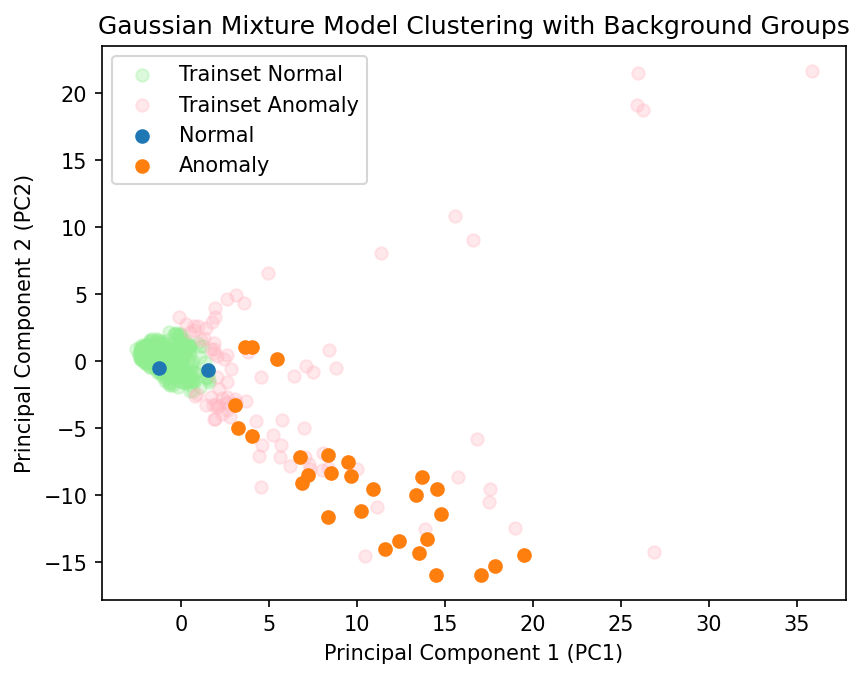

In [25]:
cluster_data = pd.concat([preped_data_from_fit,clustering_data_new], axis=0)

plot_final(cluster_data=cluster_data)

# 6.2 Discussion

As seen in the output we have many predicted classes by the decision tree which are not Blood donors and have a anomaly classified by our isolation forest (27/30 ~ 90%).
We have two cases where our decision tree classifies the patients not as Blood donors but our isolation forest classifies them with having no anomaly (index 2 & 13 ~ 7%).
We also have one cases where our decision tree classifies the patients as Blood donors but our isolation forest classifies them with having anomaly (index 25 ~ 3%).

